In [9]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import build_model
import sample
import visualization

In [10]:
model_he = build_model.make_1d_model(build_model.init_he_normal)
optimizer_he = torch.optim.Adam(model_he.parameters(), lr=0.001)

model_rai = build_model.make_1d_model(build_model.init_rai)
optimizer_rai = torch.optim.Adam(model_rai.parameters(), lr=0.001)

true_fn = sample.f1
n_epochs = 10
model_path = './output/model.obj'
x_range = (-np.sqrt(3), np.sqrt(3))

In [11]:
def train(model, true_fn, n_epochs, optimizer):
    criterion = torch.nn.MSELoss()
    x, y = sample.sample_1d(true_fn)
    tensor_x = torch.tensor(x, dtype=torch.float)
    tensor_y = torch.tensor(y, dtype=torch.float)
    dataloader = DataLoader(TensorDataset(tensor_x, tensor_y))

    for epoch in range(n_epochs):
        for i, data in enumerate(dataloader):  # Trainloader will be the training dataset
            x, y = data
            optimizer.zero_grad()

            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
    
    return model

In [12]:
model_rai = train(model_rai, true_fn, n_epochs, optimizer_rai)
model_he = train(model_he, true_fn, n_epochs, optimizer_he)
torch.save(model_he.state_dict(), model_path)

print("Finished Training")

Finished Training


In [13]:
model_he = build_model.make_1d_model(initializer=None)
model_he.load_state_dict(torch.load(model_path))

<All keys matched successfully>

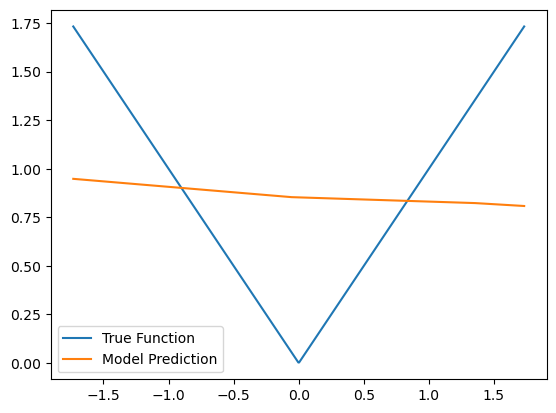

In [14]:
model_he.eval()
visualization.visualize(true_fn, model_he, x_range, 600)

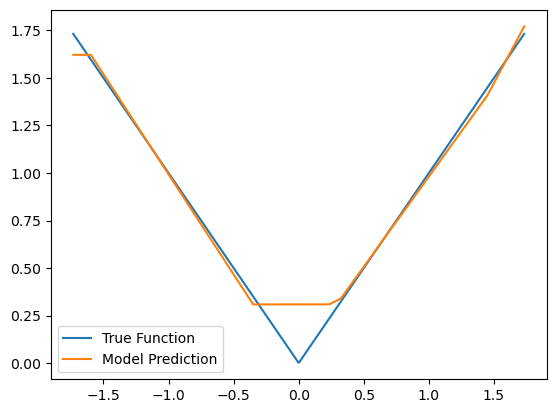

In [15]:
model_rai.eval()
visualization.visualize(true_fn, model_rai, x_range, 600)